# Credit-Card Fraud Detection

1. Download the dataset from here: [Credit Card Fraud Detection Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download)
    - Data size is greater than 100 MB to after downloading from Kaggle have compressed it using pandas as shown below:
        ```python
        # saving to disc as gunzip compressed csv
        df.to_csv('dfsavename.csv.gz', compression='gzip')
        # reading the compressed file
        df = pd.read_csv('dfsavename.csv.gz', compression='gzip')
        ```

2. In this dataset, there are 31 features out of which 28 features are numerical variables. These features are not the original features but rather the output of principal component analysis.
<br/>
3. The other 3 variables are: the time of the transaction, the amount of the transaction, and the true class of the transaction

## Import the necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 50)

# Data Visualization
import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

# Data-Prep
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection

# ML-Alogorithms
import lightgbm as lgb
import xgboost as xgb 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

print("Libraries imported!")

Libraries imported!


## Read the data

In [10]:
credit_data = pd.read_csv("./input/creditcard.csv.gz")
print(f"The dataset has {credit_data.shape[0]} rows and {credit_data.shape[1]} columns")
credit_data.head()

The dataset has 284807 rows and 31 columns


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Exploration

### 1. Basic Overview

In [11]:
useful_cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 
               'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 
               'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 
               'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

In [12]:
credit_data[useful_cols].dtypes

V1     float64
V2     float64
V3     float64
V4     float64
V5     float64
V6     float64
V7     float64
V8     float64
V9     float64
V10    float64
V11    float64
V12    float64
V13    float64
V14    float64
V15    float64
V16    float64
V17    float64
V18    float64
V19    float64
V20    float64
V21    float64
V22    float64
V23    float64
V24    float64
V25    float64
V26    float64
V27    float64
V28    float64
dtype: object

In [13]:
credit_data.isna().sum().sum()  # No Null values

0

In [14]:
credit_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [15]:
credit_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [16]:
credit_data.Class.value_counts(normalize=False)  # highly imbalanced data

0    284315
1       492
Name: Class, dtype: int64

### 2. Dive into features level

Class          2
Amount     32767
Time      124592
V3        275663
V28       275663
V27       275663
V26       275663
V25       275663
V24       275663
V23       275663
V22       275663
V21       275663
V20       275663
V19       275663
V18       275663
V17       275663
V16       275663
V1        275663
V14       275663
V13       275663
V12       275663
V11       275663
V10       275663
V9        275663
V8        275663
dtype: int64

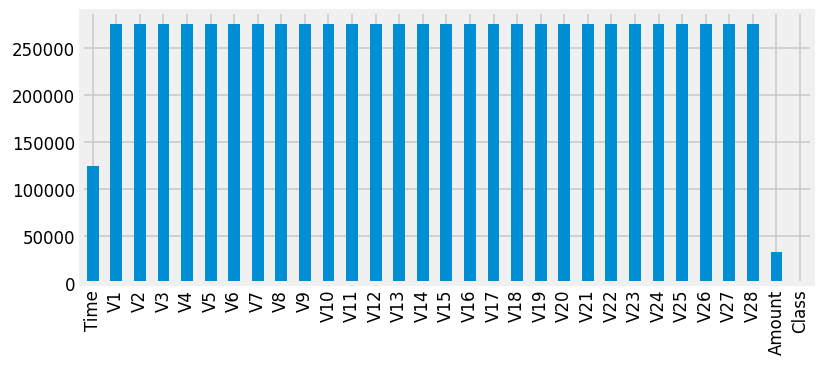

In [17]:
distinctCounter = credit_data.nunique()   # get a series containjg column name and unique value cnts 
display(distinctCounter.sort_values(ascending=True)[:25])


# plotting the distinct values
fig, ax = plt.subplots(figsize=(7, 3), dpi=120)
credit_data.nunique().plot.bar()
plt.show()

### Conclusion:
- No Null values and all the features are float dtype
- This features are after performing PCA but not are standarized
- Highly imbalanced dataset wit fraud values ~ 0.017%
- No feature is having a distinct values

-----

## Data-Preparation

In [18]:
X = credit_data.copy().drop("Class", axis=1)
y = credit_data["Class"].copy()


## Standardization
featuresToScale = X.drop(["Time"], axis=1).columns
print(featuresToScale, len(featuresToScale))  # Class and Time removed

std_scl = preprocessing.StandardScaler(copy=True)
X.loc[:, featuresToScale] = std_scl.fit_transform(X[featuresToScale])

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object') 29


In [19]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,-1.506872e-17,1.000002,-28.798555,-0.469892,0.009245,0.671694,1.253351
V2,284807.0,-9.580116e-18,1.000002,-44.035292,-0.362471,0.039657,0.486720,13.357750
V3,284807.0,-8.622104e-17,1.000002,-31.871733,-0.587214,0.118612,0.677457,6.187993
V4,284807.0,-5.189230e-18,1.000002,-4.013919,-0.599379,-0.014017,0.525008,11.918743
V5,284807.0,3.832046e-17,1.000002,-82.408097,-0.501069,-0.039367,0.443346,25.214135
V6,284807.0,9.979288e-18,1.000002,-19.636058,-0.576682,-0.205805,0.299163,55.020149
V7,284807.0,1.237432e-17,1.000002,-35.209396,-0.447886,0.032417,0.461111,97.478239
V8,284807.0,-3.193372e-18,1.000002,-61.302524,-0.174680,0.018720,0.274078,16.751534
V9,284807.0,7.234983e-19,1.000002,-12.228015,-0.585363,-0.046812,0.543531,14.194945


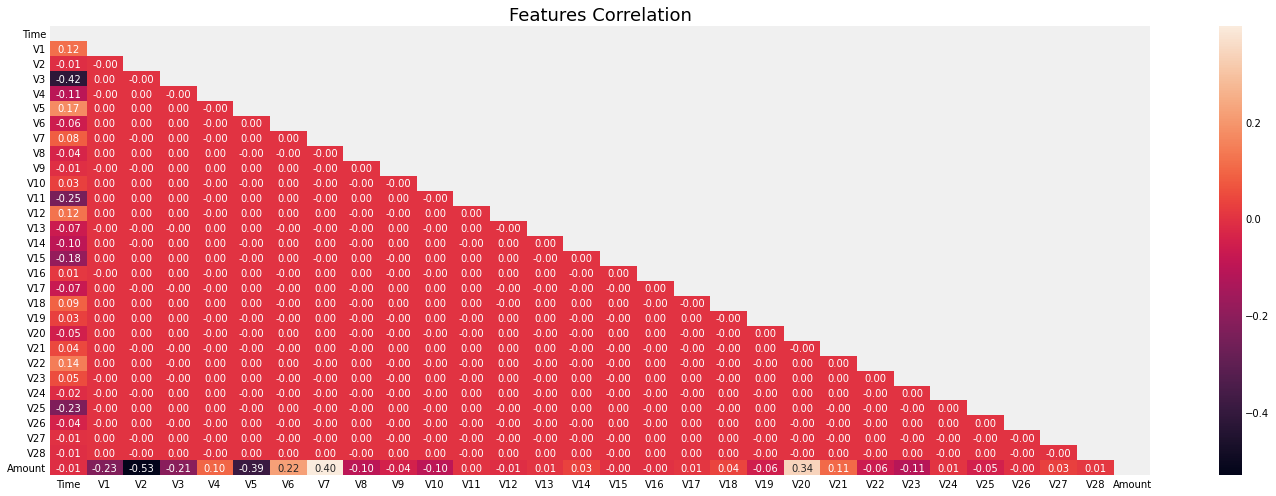

In [20]:
fig = plt.figure(figsize=(20, 7))

# Getting the Upper Triangle of the correlation matrix
corr = X.corr()
matrix = np.triu(corr)

sns.heatmap(data=corr, annot=True, fmt=".2f", mask=matrix)
plt.title("Features Correlation", size=18, color="k")
plt.tight_layout()
plt.show()

### Conclusion:
- No need to drop any features as they are generated from PCA and their is no co-linearity among each features.
- Also, No need for feature enggineering as we don't interpret these faetures. Since, these are outcome of PCA.

## Model training 

- Before evaluating the model on test-dataset, we perform cross-validation
- Once, statisfied with the model we will proceed further.

In [21]:
X_train, X_test, y_train, y_test  = model_selection.train_test_split(X, 
                                                                     y, 
                                                                     test_size=0.33,
                                                                     stratify=y,
                                                                     random_state=42,
                                                                     shuffle=True)

print(f"TRAINING INFO: {X_train.shape} {y_train.shape}")
print(f"TEST INFO: {X_test.shape} {y_test.shape}")

TRAINING INFO: (190820, 30) (190820,)
TEST INFO: (93987, 30) (93987,)


In [22]:
logres = LogisticRegression(penalty="l2", 
                            C=1.0,
                            class_weight="balanced",
                            solver="lbfgs",
                            random_state=0,
                            n_jobs=-1)

logres

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=0)

### Approach 1: Cross-validation  

In [23]:
skf  = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

training_scores = []
cross_val_scores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, columns=[0, 1])

# initiate the logistic regression model
model = logres

for train_idx, val_idx in skf.split(X_train, y_train):
    # print("TRAIN:", train_idx, "TEST:", val_idx)
    
    X_train_fold, X_val_fold = X_train.iloc[train_idx, :], X_train.iloc[val_idx, :]
    # print("TRAIN DATA:", X_train_fold.shape, X_val_fold.shape)
    
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    # print("TRAIN LABEL:", y_train_fold.shape, y_val_fold.shape)
    
    model.fit(X_train_fold, y_train_fold)
    
    y_train_preds_proba = model.predict_proba(X_train_fold)
    y_val_preds_proba = model.predict_proba(X_val_fold)
    
    predictionsBasedOnKFolds.loc[X_val_fold.index, :] =  y_val_preds_proba
    
    train_accuracy = metrics.log_loss(y_train_fold, y_train_preds_proba[:, 1])
    val_accuracy = metrics.log_loss(y_val_fold, y_val_preds_proba[:, 1])
    print(f"Training log_loss: {train_accuracy:.4f}")
    print(f"Validation log_loss: {val_accuracy:.4f}")
    print()
    
    training_scores.append(train_accuracy)
    cross_val_scores.append(val_accuracy)

print("\nCross-validation Results...")   
print(f"Average log_loss in training set: {np.mean(training_scores):.4f}")
print(f"Average log_loss in validation set: {np.mean(cross_val_scores):.4f}")

print("\nPredictionsBasedOnKFolds...")
display(predictionsBasedOnKFolds.head())

Training log_loss: 0.1552
Validation log_loss: 0.1569

Training log_loss: 0.1147
Validation log_loss: 0.1098

Training log_loss: 0.1334
Validation log_loss: 0.1291

Training log_loss: 0.1685
Validation log_loss: 0.1713

Training log_loss: 0.1501
Validation log_loss: 0.1519


Cross-validation Results...
Average log_loss in training set: 0.1444
Average log_loss in validation set: 0.1438

PredictionsBasedOnKFolds...


,0,1
198687,0.98098,0.01902
129694,0.929496,0.070504
204218,0.941071,0.058929
134361,0.930751,0.069249
173252,0.996323,0.003677


### Extra Approach 2: Cross-validation -- sklearn also provides new methods for cross-validation `cross_val_score` & `cross_validate`.
1. cross_val_score just takes on scoring metric
2. cross_validate, we can list or tuple of scoring metrics

In [44]:
# get the names of the metrics
import sklearn 
print(sklearn.metrics.get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

In [59]:
cross_val_score_results = model_selection.cross_val_score(estimator=logres,
                                                          X=X_train,
                                                          y=y_train,
                                                          scoring="roc_auc",
                                                          cv=5,
                                                          n_jobs=-1)

print(f"AUC Score across each CV: {cross_val_score_results}")
print(f"Average AUC Score : {np.mean(cross_val_score_results):.4f}")

AUC Score across each CV: [0.96927223 0.97880943 0.97884244 0.96304427 0.97365606]
Average AUC Score : 0.9727


In [60]:
_scoring = ['roc_auc', 'precision', 'recall', 'f1', "neg_log_loss"]
cross_validate_results = model_selection.cross_validate(estimator=logres,
                                                        X=X_train,
                                                        y=y_train,
                                                        scoring=_scoring,
                                                        cv=5,
                                                        n_jobs=-1,
                                                        verbose=0,
                                                        pre_dispatch=2,
                                                        return_train_score=True)

print(cross_validate_results)

{'fit_time': array([1.19408226, 1.93939376, 2.06625152, 1.02673435, 0.93415785]), 'score_time': array([0.0880065 , 0.13187289, 0.10413814, 0.10277653, 0.09158254]), 'test_roc_auc': array([0.96927223, 0.97880943, 0.97884244, 0.96304427, 0.97365606]), 'train_roc_auc': array([0.97322704, 0.98680479, 0.9883882 , 0.9752172 , 0.97622109]), 'test_precision': array([0.05835806, 0.05369718, 0.0525    , 0.05285962, 0.05591201]), 'train_precision': array([0.06238859, 0.0532146 , 0.05177578, 0.05282609, 0.0531684 ]), 'test_recall': array([0.89393939, 0.92424242, 0.95454545, 0.92424242, 0.92424242]), 'train_recall': array([0.9280303 , 0.9280303 , 0.91666667, 0.92045455, 0.9280303 ]), 'test_f1': array([0.1095636 , 0.1014975 , 0.09952607, 0.1       , 0.10544512]), 'train_f1': array([0.1169172 , 0.10065735, 0.09801539, 0.09991776, 0.10057471]), 'test_neg_log_loss': array([-0.16665937, -0.14981208, -0.12955258, -0.17261607, -0.16797026]), 'train_neg_log_loss': array([-0.16681271, -0.14663322, -0.123517

In [61]:
{
"Mean Training AUC": cross_validate_results['train_roc_auc'].mean()*100,
"Mean Validation AUC": cross_validate_results['test_roc_auc'].mean()*100,

"Mean Training Precision": cross_validate_results['train_precision'].mean(),
"Mean Validation Precision": cross_validate_results['test_precision'].mean(),

"Mean Training Recall": cross_validate_results['train_recall'].mean(),
"Mean Validation Recall": cross_validate_results['test_recall'].mean(),


"Mean Training F1 Score": cross_validate_results['train_f1'].mean(),
"Mean Validation F1 Score": cross_validate_results['test_f1'].mean(),


"Mean Training neg-log-loss Score": cross_validate_results['train_neg_log_loss'].mean(),
"Mean Validation neg-log-loss Score": cross_validate_results['test_neg_log_loss'].mean(),         
}

{'Mean Training AUC': 97.99716629919331,
 'Mean Validation AUC': 97.27248865366353,
 'Mean Training Precision': 0.05467469169076703,
 'Mean Validation Precision': 0.05466537409484771,
 'Mean Training Recall': 0.9242424242424242,
 'Mean Validation Recall': 0.9242424242424242,
 'Mean Training F1 Score': 0.10321648486579886,
 'Mean Validation F1 Score': 0.10320645795826613,
 'Mean Training neg-log-loss Score': -0.1572324616754091,
 'Mean Validation neg-log-loss Score': -0.15732207162146955}

### Note:
- For problems involving more balanced classes (i.e., the number of true positives is roughly similar to the number of true negatives), the confusion matrix may be a good.
- But For Imbalanced dataset Precision-Recall and AUC-Score are better metrics. Let's explore this

In [112]:
preds = pd.concat([y_train, predictionsBasedOnKFolds.loc[:, 1]], axis=1)
preds.columns = ["true_label", "predicted_label"]
preds.head(7)

,true_label,predicted_label
198687,0,0.01902
129694,0,0.070504
204218,0,0.058929
134361,0,0.069249
173252,0,0.003677
117040,0,0.007526
125743,0,0.000573


In [86]:
precision, recall, thresholds = metrics.precision_recall_curve(preds["true_label"], preds.predicted_label)


Plotting ROC-AUC Curve


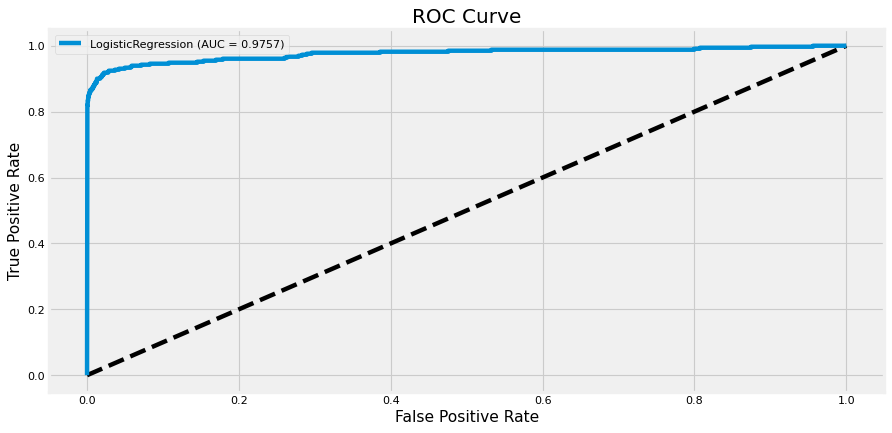

In [108]:
# Plot ROC curve
print("\nPlotting ROC-AUC Curve")
fpr, tpr, thresholds = metrics.roc_curve(preds.true_label, preds.predicted_label)
auc = metrics.auc(fpr, tpr)
fig = plt.figure(figsize=(12, 6), dpi=80)
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr, label=f'{logres.__class__.__name__} (AUC = {auc:.4f})')
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.title('ROC Curve', size=18)
plt.legend()
plt.show()  